In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout


In [2]:
ts = TimeSeries(key='0IN175LIOUOBEICW',output_format = 'pandas')
# Get json object with the intraday data and another with  the call's metadata
df, meta_data = ts.get_daily_adjusted(symbol='MMM', outputsize='full')

In [3]:
df = df.rename(columns = {'1. open':'Open','2. high':'High', '3. low':'Low', 
                 '4. close':'Close', '5. adjusted close':'Price', '6. volume':'Volume',
                 '7. dividend amount':'Dividends', '8. split coefficient':'Stock Splits'})
df = df[['Open', 'High', 'Low', 'Volume','Close', 'Stock Splits','Dividends', 'Price']]
df.dropna(inplace=True)

# top should be olders
df = df.sort_values(by='date')

#generate look ahead 
df = df.resample('M').last()
df['lookahead'] = df['Close'].shift(-1)
df.head()
df.tail()

,Open,High,Low,Volume,Close,Stock Splits,Dividends,Price,lookahead
date,,,,,,,,,
2021-04-30,197.66,198.9900,196.13,2507080.0,197.14,1.0,0.0,195.703643,203.04
2021-05-31,203.88,204.3921,202.80,1741191.0,203.04,1.0,0.0,203.040000,198.63
2021-06-30,195.90,198.9800,195.54,2592085.0,198.63,1.0,0.0,198.630000,197.94
2021-07-31,198.00,199.2400,197.20,1910332.0,197.94,1.0,0.0,197.940000,200.58
2021-08-31,201.23,201.7100,200.29,1910301.0,200.58,1.0,0.0,200.580000,NaN


In [4]:
df.tail(10)['lookahead']

date
2020-11-30    174.79
2020-12-31    175.66
2021-01-31    175.06
2021-02-28    192.68
2021-03-31    197.14
2021-04-30    203.04
2021-05-31    198.63
2021-06-30    197.94
2021-07-31    200.58
2021-08-31       NaN
Freq: M, Name: lookahead, dtype: float64

# Data Exploration

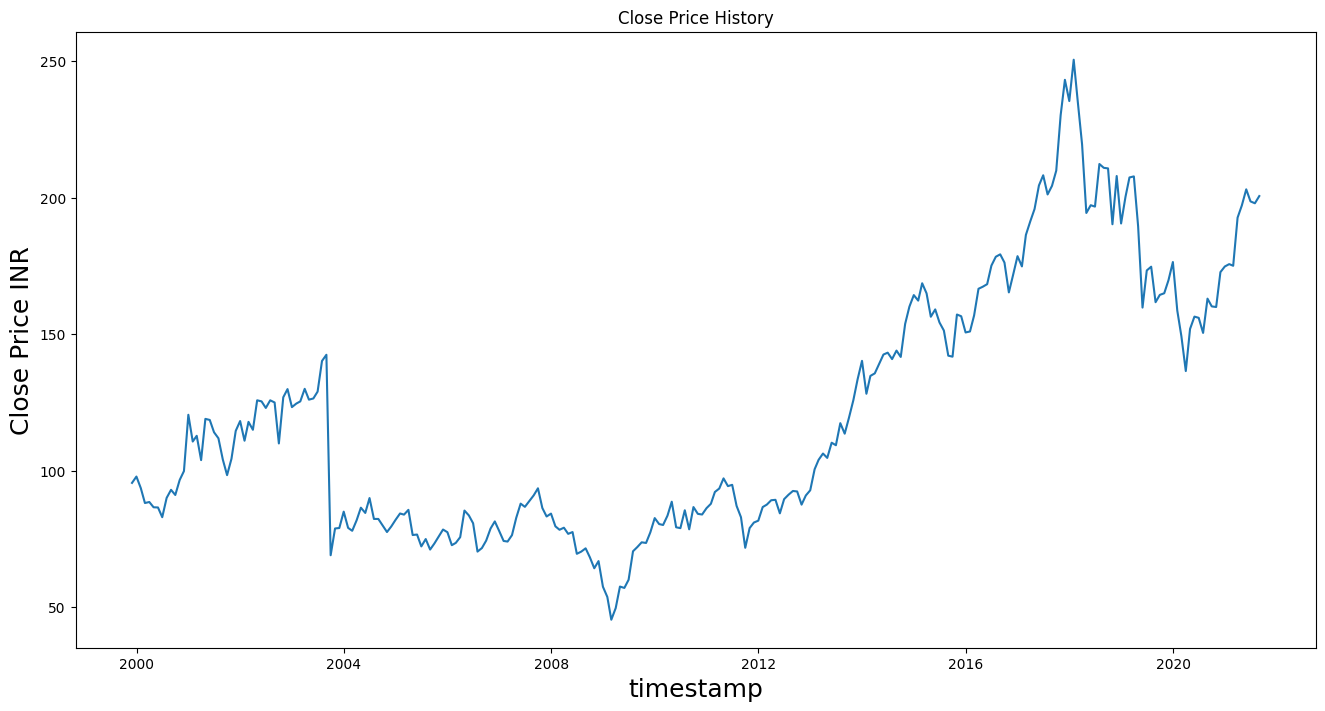

In [5]:
#drop nulls 
import seaborn as sns
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
#ax=sns.lineplot(data=df, x='timestamp',y='close', color="blue");
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()

### Historgram of Returns

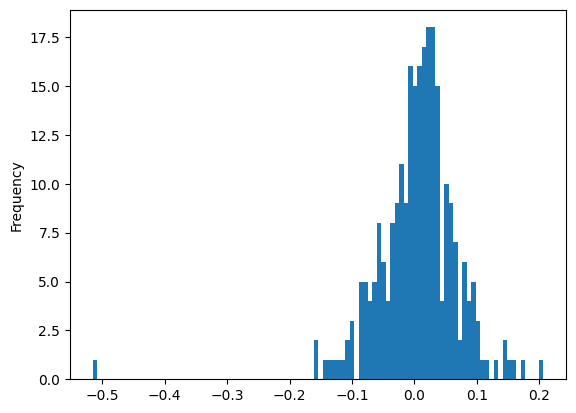

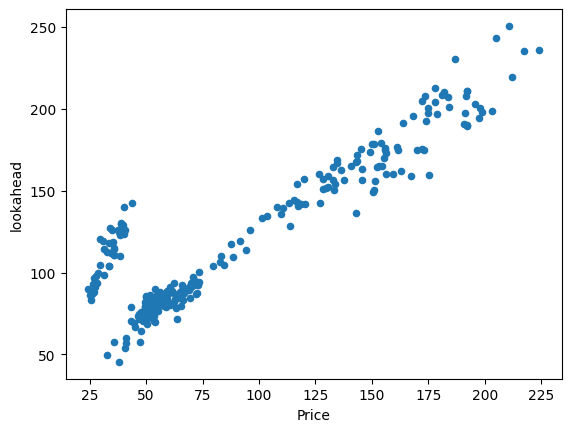

In [6]:
df['Close'].pct_change().plot(kind='hist', bins=100)
None
plt.show()

#correlation between today and lookahead
pd.concat([df['Price'],df['lookahead']],axis='columns').corr()
df.plot(x ='Price', y = 'lookahead', kind = 'scatter')
plt.show()

### Bring in Additional Features

#### Correlation Analaysis

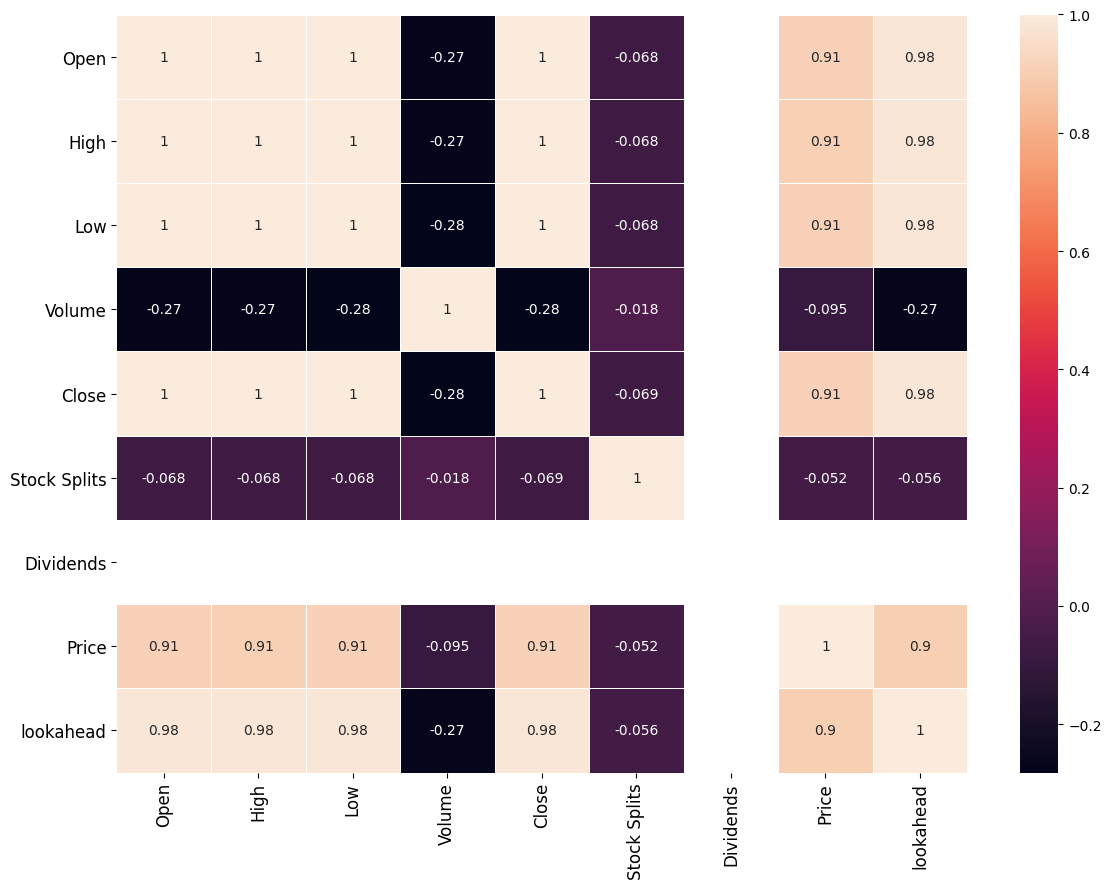

In [8]:
corr = df.corr()
import seaborn as sns
plt.figure(figsize=[12,9])
ax = sns.heatmap(corr, annot=True, linewidths=.5)
plt.yticks(rotation=0, size = 12); 
plt.xticks(rotation=90, size = 12)  
plt.tight_layout()  
plt.show()

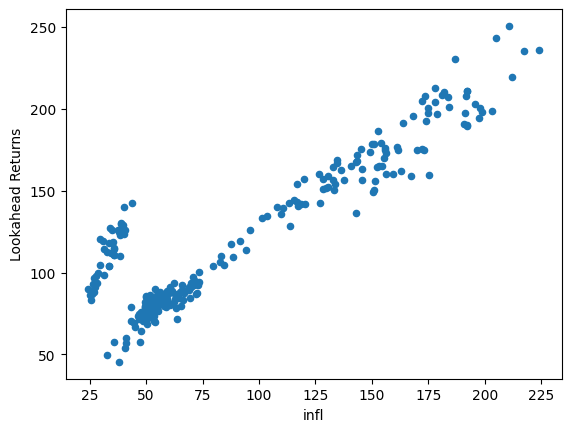

In [9]:
# Scatter plot the predictive performance of the inflation indicator
ax = df.plot(kind ='scatter', x='Price', y='lookahead')
ax.set_xlabel("infl")
ax.set_ylabel("Lookahead Returns")

plt.show()

## Data Processing

#### Convert to numpy array

In [10]:
#get dates and closing prices
data = df.filter(['lookahead'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)
print(data.shape)
training_data_len

(262, 1)


210

### Scaling data to 0 to 1

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
print(scaled_data.shape)

(262, 1)


#### Create x and y training data

In [12]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
train_labels =[]
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    

test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


print(type(x_train))
print(len(x_train))

<class 'list'>
150


In [13]:
training_data_len

210

### Spliting for train and test

In [14]:
#convert into arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape
#same for training
x_test = np.array(x_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(150, 60)
(150,)
(52, 60)


In [15]:
# Convert into 3 D
X_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_train.shape

(150, 60)

## Model

#### Building the Model

In [16]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

#### Train with adam optimizer and mean squared error as loss function

In [17]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=1,batch_size=32)

5/5 [==============================] - 0s 44ms/step - loss: 0.0848


## Prediction

In [18]:
test_predictions = model.predict(x_test)
test_predictions = sc.inverse_transform(test_predictions)
train_predictions = model.predict(X_train)
train_predictions = sc.inverse_transform(train_predictions)
print("Train Preds: ", train_predictions.shape)
print("Test Preds: ", test_predictions.shape)

Train Preds:  (150, 1)
Test Preds:  (52, 1)


### Plotting Predictions

<ipython-input-22-7848a0bc7c9d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['Predictions (OOS)'] = test_predictions


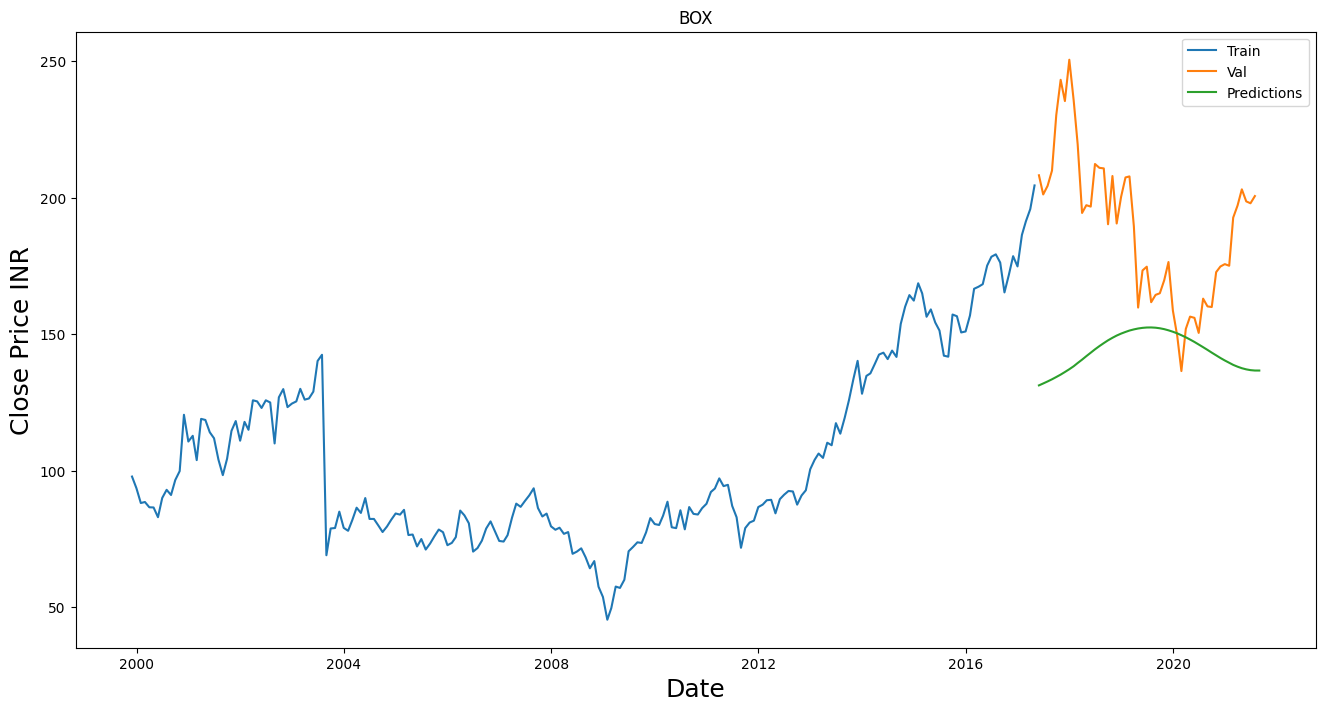

,lookahead,Predictions (OOS)
date,,
2021-04-30,203.04,137.552002
2021-05-31,198.63,137.129486
2021-06-30,197.94,136.845047
2021-07-31,200.58,136.701706
2021-08-31,NaN,136.697388


In [22]:
train = data[:training_data_len]
display = data[training_data_len:]
display['Predictions (OOS)'] = test_predictions
plt.figure(figsize=(16,8))
plt.title('BOX')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['lookahead'])
plt.plot(display['lookahead'])
#plt.plot(train['Predictions (IS)'])
plt.plot(display['Predictions (OOS)'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()
display.tail()